# Goal: Explore Conditional GAN

Based on the excellent tutorial [here](https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/Conditional-GAN.ipynb).

By formulating the process as a two-player game, Generative Adversarial Networks (GANs) can be very effective in generating realistic content. However, we may want to have more control over what is generated. Conditional GANs offer more control by letting us specify the *class* of output we want. Then we hand the generated content and the class it's supposed to be to the discriminator. The disciminator attempts to differentiate between the generated content of a certain class and the real content of a certain class.

The original paper that described conditional GANs is [here](https://arxiv.org/abs/1411.1784). And here is the setup for a classic GAN:

![](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/gan.svg)

Here are the objectives of the two networks:
- $G(z) \rightarrow$ produce a (hopefully) real-looking image
- $D(image) \rightarrow$ probability of an image being real (0 is fake, 1 is real)

We will be extending this setup by concatinating the class we would like to output as a one-hot vector to both the generator and the discriminator. 

## Imports

As always, we load lots of libraries.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Understanding the GAN Loss Function
Before implementing the conditional GAN, let's look over the training objectives of both networks. The objective function used in GANS is:

$\min_{G}\max_{D} \left( \mathbb{E}_{x\sim p_{\text{data}}(x)}\left[\log{D(x)}\right] +  \mathbb{E}_{z\sim p_{\text{z}}(z)}\left[\log{\left(1 - D(G(z))\right)}\right] \right)$



So we see that the generator tries to minimize this cost function while the discriminator tries to maximize both terms. The first term represents the discriminator's ability to identify a real image. The second term represents the discriminator's ability to correctly identify fake images generated by the generator. **Note that both terms in our cost function are essentially cross-entropy loss terms for a binary classification problem of identifying an image as being either real or fake**.


Let's plot both terms:

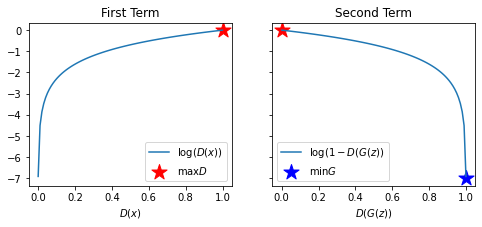

In [10]:
fix, ax = plt.subplots(1,2, sharey=True, figsize=(8,3))
xs = np.linspace(0.001,0.999,100) # D(x) or D(G(z))
ax[0].plot(xs, np.log(xs), label=r'$\log(D(x))$')
ax[0].set_xlabel("$D(x)$")
ax[0].scatter(1,0,marker="*",color='red', s=2**8, label='$\max D$')
ax[0].set_title("First Term")
ax[0].legend();
ax[1].plot(xs, np.log(1-xs), label=r'$\log(1 - D(G(z))$')
ax[1].set_xlabel("$D(G(z))$")
ax[1].scatter(0, 0,marker="*",color='red', s=2**8)
ax[1].scatter(1,-7, marker='*', color='blue', s=2**8, label='$\min G$')
ax[1].set_title("Second Term")
ax[1].legend();

### The Discriminator's Perspective 
Note that the for the first term, $D(x) \rightarrow 1$ means that the discriminator is able to **correctly identify a real image** (i.e. with probability 1, this is a real image). Thus the discriminator wants to maximize the value of the first term. Looking at the second term, $D(G(z)) \rightarrow 0$ means that the discriminator is able to **correctly identify a fake, generated image** (i.e. with probability 0, this is a real image). And so the discriminator would want to maximimize value of the second term. 

### The Generator's Perspective
Here, the first term is independent of the generator so we only look at the second term. The generator would like $D(G(z)) \rightarrow 1$, which means the generator is able to generate fake images that **fool the discriminator**. So, even though $G(z)$ is a fake image, the discriminator assigns a high probability of this image being real. And so the generator would like to minimize the value of the second term.

### Conditional GAN Loss Function
We simply augment the input to the generator and the discriminator to contain the class we would like to generate.

$\min_{G}\max_{D} \left( \mathbb{E}_{x\sim p_{\text{data}}(x)}\left[\log{D(x,c)}\right] +  \mathbb{E}_{z\sim p_{\text{z}}(z)}\left[\log{\left(1 - D(G(z,c),c)\right)}\right] \right)$.

## MNIST Data

For this demo, we will be using the MNIST data set. We can apply GANs to other datasets but the training process takes much longer. Our goal will be to supply random noise and a class label (e.g. a digit between 0 and 9) to the generator and produce an image of that particular digit.

In [21]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])])

data = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

A couple of things to note: we drop the last batch in our training set. We do this so that each batch passed into our networks is always of size 64 (since the number of training samples isn't divisible by 64). Also take a careful look at our normalization factors ($\mu, \sigma=0.5$). By using these normalization factors, we constrain each pixel value in our image to within $[-1, 1]$:

In [23]:
images, _ = next(iter(data_loader))
print("min pixel value:", images.min())
print("max pixel value:", images.max())
print("avg pixel value:", images.mean())

min pixel value: tensor(-1.)
max pixel value: tensor(1.)
avg pixel value: tensor(-0.7313)


This normalization strategy will come in handy for our generator: the last-layer activation function will be `tanh` which is also constrained to be within $[-1,1]$.

## Building $G$ and $D$
We will be using MLPs for both the generator and the discriminator, so we will also think of our images as being flattened. 
### The Generator $G$

Inputs:
- a random noise vector (we set it to 100 in this notebook)
- a one-hot encoded class label (e.g. class label 4 becomes $[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]$

Output:
- an image (a flattened $28 \times 28$ grayscale image)

### The Discriminator $D$

Input:
- an image (a flattened $28 \times 28$)

Output:
- a single real value within $[0, 1]$. Probabily 0 represents a low confidence that the input image is real. Probability 1 represents a high confidence that the input image is real.

Carefully check the inputs and outupts of each network below to make sure they match our description above. Note the use of `tanh`, `sigmoid`, and [`LeakyReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html).

In [28]:
class Generator(nn.Module):
    def __init__(self, noise_size=100, num_classes=10, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(noise_size+num_classes, 128), # [noise input, one-hot label] concatenated 
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size), # flattened image
            nn.Tanh() # min value: -1, max value: 1
        )
        
    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [noise input, one-hot label] concatenated vector
        y_ = self.network(v)
        y_ = y_.view(x.size(0), 1, 28, 28) # flattened image
        return y_

In [29]:
class Discriminator(nn.Module):
    def __init__(self, image_size=28*28, num_classes=10, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(image_size+num_classes, 512),   # [flattened image, one-hot label] concatenated vector
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(), #min value: 0, max value: 1 -> great for probabilities!
        )
    
    def forward(self, x, c):        
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [flattened image, one-hot label] concatenated vector
        y_ = self.network(v)
        return y_

## Training Setup

Now, we're ready to instantiate our models, hyperparameters, and optimizers. Since the task is so easy for MNIST, we will train for only 10 epochs. We will update the generator and discriminator in every step but often one can be trained more frequently than the other. We need to instantiate two optimizers: one for each newtork. 

In [32]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", DEVICE)

D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

max_epoch = 10
step = 0
n_noise = 100 # size of noise vector

criterion = nn.BCELoss() # binary-cross entropy loss
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We will denote real images as having a label 1 and fake images as having a label of 0
# This is why we needed to drop the last batch of the data loader
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real image
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake image

device: cuda


## Training
Now, let's train both networks. Remember that we will have two loss terms for the discriminator and one loss term for the generator. 

Small Caveat: You'll notice a subtle difference in the generator's loss function compared to what we discussed earlier. Watch a few minutes of this part of a [lecture from CS231N](https://youtu.be/5WoItGTWV54?t=3531) to see why!

In [33]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        x = images.to(DEVICE)
        y = labels.to(DEVICE)
        y = F.one_hot(y, num_classes=10)
        

        # Discriminator - Real Images
        x_outputs = D(x, y)                              # pass images and class labels to discriminator
        D_x_loss = criterion(x_outputs, D_labels)        # Discriminator loss for real images
        
        # Discriminator - Fake Images
        z = torch.randn(batch_size, n_noise).to(DEVICE)  # sample from standard dist.
        z_ = G(z,y)                                      # pass noise and class label to generator
        z_outputs = D(z_, y)                             # pass fake images and label to discriminator
        D_z_loss = criterion(z_outputs, D_fakes)         # Discriminator loss for fake images
        
        D_loss = D_x_loss + D_z_loss                     # Total Discriminator loss
        
        # Optimize the Discriminator
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        # Generator - Fake Images
        z = torch.randn(batch_size, n_noise).to(DEVICE)  # sample from standard dist.
        z_ = G(z,y)                                      # pass noise and class label to generator
        z_outputs = D(z_, y)                             # pass fake images and label to discriminator
        G_loss = -1 * criterion(z_outputs, D_fakes)      # Generator loss is negative disciminator fake-loss

        # Optimize the Generator
        G.zero_grad()
        G_loss.backward()
        G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.383345365524292, G Loss: -0.6775472164154053
Epoch: 0/10, Step: 500, D Loss: 1.3113811016082764, G Loss: -0.5134172439575195
Epoch: 1/10, Step: 1000, D Loss: 1.415831446647644, G Loss: -0.26758670806884766
Epoch: 1/10, Step: 1500, D Loss: 0.8949247002601624, G Loss: -0.5527048110961914
Epoch: 2/10, Step: 2000, D Loss: 1.3046650886535645, G Loss: -0.5584967732429504
Epoch: 2/10, Step: 2500, D Loss: 1.239891767501831, G Loss: -0.45827552676200867
Epoch: 3/10, Step: 3000, D Loss: 1.4110296964645386, G Loss: -0.5067005157470703
Epoch: 3/10, Step: 3500, D Loss: 1.1709760427474976, G Loss: -0.5282682180404663
Epoch: 4/10, Step: 4000, D Loss: 1.213775396347046, G Loss: -0.6103003621101379
Epoch: 4/10, Step: 4500, D Loss: 1.258767008781433, G Loss: -0.5418068766593933
Epoch: 5/10, Step: 5000, D Loss: 1.3338922262191772, G Loss: -0.5702112913131714
Epoch: 5/10, Step: 5500, D Loss: 1.3585987091064453, G Loss: -0.7409588098526001
Epoch: 6/10, Step: 6000, D Loss: 1.

## Generate Samples (Conditioned on the class label!)
Let's generate a few samples now! Don't forget to set the generator to `eval` mode. We have layers in our generator that work differently during training and inference time (which one?). Let's set the class label to 8 and generate a few samples.

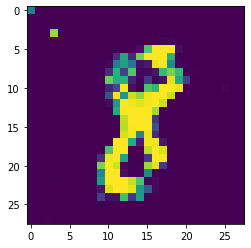

In [36]:
G.eval()

z = torch.randn(1, n_noise).to(DEVICE)          # random noise vector 1x100

label = 8
label = torch.tensor([label])
c = F.one_hot(label, num_classes=10).to(DEVICE) # one-hot encoding 1x10

y_hat = G(z, c).view(1, 28, 28)
plt.imshow(y_hat.squeeze().detach().cpu())

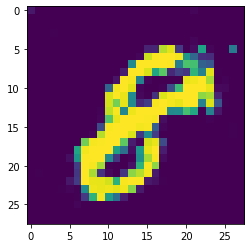

In [37]:
G.eval()

z = torch.randn(1, n_noise).to(DEVICE)          # random noise vector 1x100

label = 8
label = torch.tensor([label])
c = F.one_hot(label, num_classes=10).to(DEVICE) # one-hot encoding 1x10

y_hat = G(z, c).view(1, 28, 28)
plt.imshow(y_hat.squeeze().detach().cpu())

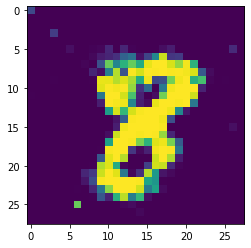

In [38]:
G.eval()

z = torch.randn(1, n_noise).to(DEVICE)          # random noise vector 1x100

label = 8
label = torch.tensor([label])
c = F.one_hot(label, num_classes=10).to(DEVICE) # one-hot encoding 1x10

y_hat = G(z, c).view(1, 28, 28)
plt.imshow(y_hat.squeeze().detach().cpu())

And that's it! In this demo, we explored conditional GANs and looked a bit closely at the loss function used in GANs. Since GANs, there have been newer generative models such as diffusion models. 